<a href="https://colab.research.google.com/github/fnzl54/Data-Analysis-Final-Project/blob/main/202010529_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **202010529 권찬영 데이터분석프로그래밍 final project**
매출과 기업의 주가의 상관관계를 분석하는 코드이며 나아가 기계학습을 통해 매출 발표 이후 주가의 방향을 예측하는 모델을 제작하는 프로젝트입니다.

사용한 dataset은 Kaggle에서 “기업명 stock data”로 검색하면 나오는 datasets를 사용하였으며 매출은 investing.com에서 실적 창에 나오는 데이터를 통해 직접 .csv파일을 만들어서 사용했습니다.

github의 Data-Analysis-Final-Project의 main에 필요한 파일 27개가 업로드 되어있습니다.

WordCloud에서 한글을 사용하기 위한 나눔 폰트 설치 코드입니다.

(첫번째 코드를 실행하고 런타임 다시 시작을 해야 합니다)

In [33]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from wordcloud import WordCloud

plt.rc('font', family='NanumBarunGothic')

파일을 colab에 업로드 하는 코드로 github에 올린 파일을 모두 업로드하면 됩니다.

In [2]:
myfile = files.upload()

Saving Amzm earning.csv to Amzm earning.csv
Saving AMZN.csv to AMZN.csv
Saving apple earning.csv to apple earning.csv
Saving Apple Stock.csv to Apple Stock.csv
Saving BMDOHYEON_otf.otf to BMDOHYEON_otf.otf
Saving F earning.csv to F earning.csv
Saving F.csv to F.csv
Saving FB earning.csv to FB earning.csv
Saving FB.csv to FB.csv
Saving GOOG earning.csv to GOOG earning.csv
Saving GOOG.csv to GOOG.csv
Saving Nfls earning.csv to Nfls earning.csv
Saving NFLX.csv to NFLX.csv
Saving nvda earning.csv to nvda earning.csv
Saving Nvidia.csv to Nvidia.csv
Saving PFE earning.csv to PFE earning.csv
Saving PFE.csv to PFE.csv
Saving QCOM earning.csv to QCOM earning.csv
Saving QCOM.csv to QCOM.csv
Saving Starbucks earning.csv to Starbucks earning.csv
Saving Starbucks_stock_history.csv to Starbucks_stock_history.csv
Saving Tsla earning.csv to Tsla earning.csv
Saving TSLA.csv to TSLA.csv
Saving TSM earning.csv to TSM earning.csv
Saving TSM.csv to TSM.csv
Saving UBER earning.csv to UBER earning.csv
Saving

# 1. 조사할 주식을 파악하기 위해 검색어 상위 종목을 찾는 과정입니다.

네이버에서 데이터 크롤링을 하는 코드이며 실행시 3분 정도 소요됩니다

https://www.youtube.com/watch?v=yQ20jZwDjTE - '나도 코딩' 유튜브에서 배워서 크롤링을 사용했습니다.

In [3]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import time

title = []
summary = []

for n in tqdm(range(1, 1000, 10)): #1~100페이지의 뉴스 탭을 크롤링하는 과정입니다.
  url = requests.get(f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%ED%95%B4%EC%99%B8%EC%A3%BC%EC%8B%9D%EC%A2%85%EB%AA%A9&sort=0&photo=0&field=0&pd=0&ds=&de=&cluster_rank=37&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:all,a:all&start={n}")
  html = BeautifulSoup(url.text)

  for i in html.find('ul', class_ = 'list_news').find_all('li', class_ = 'bx'): #가지고 온  html에서 원하는 테그를 불러오는 코드입니다.
    title.append(i.find('a' , class_ = 'news_tit').text)
    summary.append(i.find('div' , class_ = 'news_dsc').text)

  time.sleep(0.3) #웹사이트에 무리를 주지 않기 위해 간격을 주는 코드입니다.

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


크롤링한 데이터를 WordCloud 형태로 출력하는 코드로 데이터에 기업과 관계 없는 단어와 부사등을 전처리하였습니다.

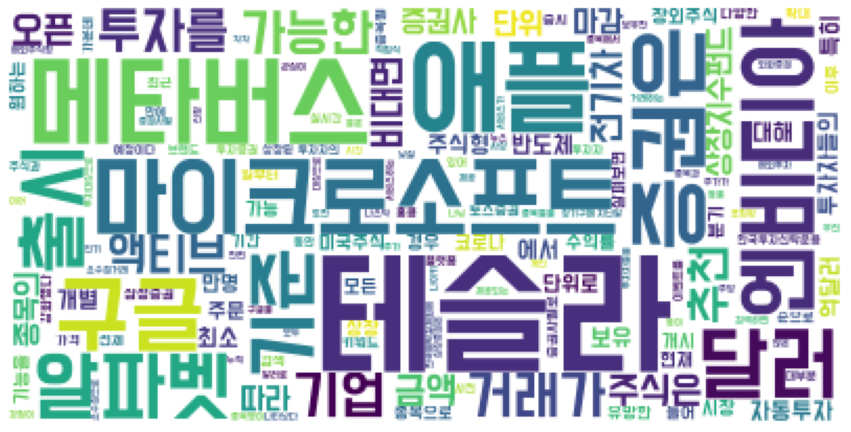

In [4]:
import re

t = ''

for i in title:
  t += i
  t += ' '

for i in summary:
  t += i
  t += ' '

box = []

for i in re.findall('[가-힣]+', t):
  if len(i) > 1:
    box.append(i)

dic = {}

for i in box:
  if i not in dic:
    dic[i] = 1
  else:
    dic[i] += 1

del dic['해외'], dic['주식'], dic['해외주식'], dic['소수점'], dic['종목'], dic['국내'], dic['거래'], dic['미국'], dic['종목은'] , dic['있다'], dic['서비스'] , dic['종목을'] , dic['투자'] , dic['있는'] , dic['증권'] , dic['서학개미'] , dic['최대'] , dic['올해'] , dic['내년'] , dic['서비스를'] , dic['상위'] , dic['통해'] , dic['가장'] , dic['매매'] , dic['종목이'] , dic['순매수'] , dic['글로벌'] , dic['주식을'] , dic['돌파'] , dic['중국'], dic['한국투자증권'] , dic['이벤트'] , dic['종목에'] , dic['지난'] , dic['만달러'] , dic['억원'] , dic['유망'] , dic['따르면'] , dic['만원'] , dic['많이'] , dic['대한'], dic['해당'] , dic['일까지'] , dic['이상'] , dic['투자자들이'] , dic['이달'] , dic['것으로'] , dic['높은'] , dic['해외주식을'] , dic['고객'] , dic['미래에셋증권'], dic['관련'] , dic['밝혔다'] , dic['위해'] , dic['투자하는'] , dic['주요'] , dic['유진투자증권'] 
# 크롤링한 데이터 자체는 모든 단어를 가지고 있어서 필요없는 단어를 전처리 하였습니다.

wc = WordCloud(font_path = 'BMDOHYEON_otf.otf', background_color='white').generate_from_frequencies(dic)

plt.figure(figsize = (15, 10))
plt.axis('off')
plt.imshow(wc)
plt.show()

# 2. 데이터를 불러와서 전처리 하는 과정입니다. (13개 기업)
(애플, 구글, 페이스북, 아마존, 넷플릭스, 테슬라, 엔비디아, 스타벅스, 포드, 화이자, TSMC, 퀄컴, 우버)

csv파일을 colab에 업로드하는 코드입니다.

In [5]:
AppleStockDf = pd.read_csv('Apple Stock.csv', encoding='CP949', parse_dates=['Date'])
AppleEarningDf = pd.read_csv('apple earning.csv', parse_dates=['Date'])
FbStockDf = pd.read_csv('FB.csv', encoding='CP949', parse_dates=['Date'])
FbEarningDf = pd.read_csv('FB earning.csv', parse_dates=['Date'])
GoogStockDf = pd.read_csv('GOOG.csv', encoding='CP949', parse_dates=['Date'])
GoogEarningDf = pd.read_csv('GOOG earning.csv', parse_dates=['Date'])
AmznStockDf = pd.read_csv('AMZN.csv', encoding='CP949', parse_dates=['Date'])
AmznEarningDf = pd.read_csv('Amzm earning.csv', parse_dates=['Date'])
NfisStockDf = pd.read_csv('NFLX.csv', encoding='CP949', parse_dates=['Date'])
NfisEarningDf = pd.read_csv('Nfls earning.csv', parse_dates=['Date'])
TslaStockDf = pd.read_csv('TSLA.csv', encoding='CP949', parse_dates=['Date'])
TslaEarningDf = pd.read_csv('Tsla earning.csv', parse_dates=['Date'])
NvdaStockDf = pd.read_csv('Nvidia.csv', encoding='CP949', parse_dates=['Date'])
NvdaEarningDf = pd.read_csv('nvda earning.csv', parse_dates=['Date'])
SbuxStockDf = pd.read_csv('Starbucks_stock_history.csv', encoding='CP949', parse_dates=['Date'])
SbuxEarningDf = pd.read_csv('Starbucks earning.csv', parse_dates=['Date'])
FStockDf = pd.read_csv('F.csv', encoding='CP949', parse_dates=['Date'])
FEarningDf = pd.read_csv('F earning.csv', parse_dates=['Date'])
PfeStockDf = pd.read_csv('PFE.csv', encoding='CP949', parse_dates=['Date'])
PfeEarningDf = pd.read_csv('PFE earning.csv', parse_dates=['Date'])
TsmStockDf = pd.read_csv('TSM.csv', encoding='CP949', parse_dates=['Date'])
TsmEarningDf = pd.read_csv('TSM earning.csv', parse_dates=['Date'])
QcomStockDf = pd.read_csv('QCOM.csv', encoding='CP949', parse_dates=['Date'])
QcomEarningDf = pd.read_csv('QCOM earning.csv', parse_dates=['Date'])
UberStockDf = pd.read_csv('UBER.csv', encoding='CP949', parse_dates=['Date'])
UberEarningDf = pd.read_csv('UBER earning.csv', parse_dates=['Date'])

Apple 주식을 전처리하는 코드입니다.

In [6]:
AppleStockDf.drop(['High', 'low','volume','adjClose','adjHigh','adjLow','adjOpen','adjVolume', 'divCash','splitFactor','symbol'], axis=1, inplace=True)
AppleStockDf['Date'] = AppleStockDf['Date'].dt.strftime("%Y-%m-%d")
AppleStockDf['Date'] = pd.to_datetime(AppleStockDf['Date'], infer_datetime_format=True)

Apple = pd.merge(AppleStockDf, AppleEarningDf)

Apple['매출 증감소량'] = (Apple['매출'] - Apple['예측'])/Apple['예측'] * 100 # 매출의 예측치 보다 실제 발표치의 증감소량을 백분율로 나타낸 변수입니다.
Apple['주가 증감소량'] = (Apple['Close'] - Apple['Open'])/Apple['Open'] * 100 # 실적 발표 날의 시작가에서 종가의 증감소량 백분율로 나타낸 변수 입니다.

AppleEarningDf['Date'] = pd.DatetimeIndex(AppleEarningDf['Date']) - timedelta(days=1)
Apple_1d_before = pd.merge(AppleStockDf, AppleEarningDf)
Apple['1d_before_주가 증감소량'] = (Apple['Close'] - Apple_1d_before['Close'])/Apple_1d_before['Close'] * 100 # 실적 발표 날 종가가 전날 종가와 증감소량을 백분률로 나타낸 변수 입니다.

AppleEarningDf['Date'] = pd.DatetimeIndex(AppleEarningDf['Date']) + timedelta(days=2)
Apple_1d_after = pd.merge(AppleStockDf, AppleEarningDf)
Apple['1d_after_주가 증감소량'] = (Apple_1d_after['Close'] - Apple['Close'])/Apple['Close'] * 100 # 실적 발표 다음 날 종가가 실적 발표 날과의 증감소량을 백분율로 나타낸 변수입니다.

AppleEarningDf['Date'] = pd.DatetimeIndex(AppleEarningDf['Date']) - timedelta(days=1)
AppleEarningDf['Date'] = pd.DatetimeIndex(AppleEarningDf['Date']) - timedelta(weeks=1)
Apple_1w_before = pd.merge(AppleStockDf, AppleEarningDf)
Apple['1w_before_주가 증감소량'] = (Apple['Close'] - Apple_1w_before['Close'])/Apple_1w_before['Close'] * 100 # 실적 발표 날 종가가 전주 종가와 증감소량을 백분률로 나타낸 변수 입니다.

AppleEarningDf['Date'] = pd.DatetimeIndex(AppleEarningDf['Date']) + timedelta(weeks=2)
Apple_1w_after = pd.merge(AppleStockDf, AppleEarningDf)
Apple['1w_after_주가 증감소량'] = (Apple_1w_after ['Close'] - Apple ['Close'])/Apple['Close'] * 100 # 실적 발표 다음 주 종가가 실적 발표 날과의 증감소량을 백분율로 나타낸 변수입니다.

Apple['발표 이전'] = (Apple_1d_before['Close'] - Apple_1w_before['Close'])/Apple_1w_before['Close'] * 100 # 실적 발표 전날 종가가 실적 발표 전주 종가와 증감소량을 백분률로 나타낸 변수입니다.
Apple


,Date,Close,Open,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-30,200.67,203.06,58.02,57.510,0.886802,-1.176992,-1.925615,4.908556,-3.282244,1.091344,-1.383266
1,2019-07-30,208.78,208.76,53.81,53.320,0.918980,0.009580,-0.429225,2.040425,-0.028730,-5.642303,0.402222
2,2019-10-30,243.26,244.76,64.04,63.010,1.634661,-0.612845,-0.012331,2.260955,0.032897,5.746937,0.045234
3,2020-01-28,317.69,312.60,91.82,88.510,3.739690,1.628279,2.828937,2.093236,0.353792,0.365136,-2.407051
4,2020-04-30,293.80,289.96,58.31,54.900,6.211293,1.324321,2.109617,-1.609939,6.824710,3.383254,4.617678
5,2020-07-30,384.76,376.75,59.69,52.290,14.151845,2.126078,1.210017,10.468864,3.602779,18.414076,2.364155
6,2020-10-29,115.32,112.37,64.70,63.800,1.410658,2.625256,3.705036,-5.601804,-0.371490,3.217135,-3.930886
7,2021-01-27,142.06,143.43,111.44,103.270,7.911300,-0.955170,-0.768371,-3.498522,7.596758,-5.715895,8.429902
8,2021-04-28,133.58,134.31,89.58,77.278,15.919149,-0.543519,-0.602723,-0.074862,0.059925,-4.102411,0.666667


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


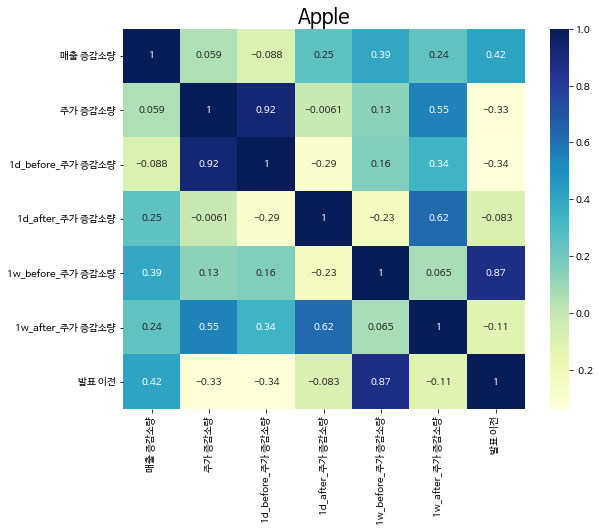

In [7]:
corr = Apple.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Apple', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

메타(페이스북) 주식을 전처리하는 코드입니다.

In [8]:
FbStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
FbStockDf['Date'] = FbStockDf['Date'].dt.strftime("%Y-%m-%d")
FbStockDf['Date'] = pd.to_datetime(FbStockDf['Date'], infer_datetime_format=True)

Fb = pd.merge(FbStockDf, FbEarningDf)
Fb['매출 증감소량'] = (Fb['매출'] - Fb['예측'])/Fb['예측'] * 100
Fb['주가 증감소량'] = (Fb['Close'] - Fb['Open'])/Fb['Open'] * 100

FbEarningDf['Date'] = pd.DatetimeIndex(FbEarningDf['Date']) - timedelta(days=1)
Fb_1d_before = pd.merge(FbStockDf, FbEarningDf)
Fb['1d_before_주가 증감소량'] = (Fb['Close'] - Fb_1d_before['Close'])/Fb_1d_before['Close'] * 100

FbEarningDf['Date'] = pd.DatetimeIndex(FbEarningDf['Date']) + timedelta(days=2)
Fb_1d_after = pd.merge(FbStockDf, FbEarningDf)
Fb['1d_after_주가 증감소량'] = (Fb_1d_after['Close'] - Fb['Close'])/Fb['Close'] * 100

FbEarningDf['Date'] = pd.DatetimeIndex(FbEarningDf['Date']) - timedelta(days=1)
FbEarningDf['Date'] = pd.DatetimeIndex(FbEarningDf['Date']) - timedelta(weeks=1)
Fb_1w_before = pd.merge(FbStockDf, FbEarningDf)
Fb['1w_before_주가 증감소량'] = (Fb['Close'] - Fb_1w_before['Close'])/Fb_1w_before['Close'] * 100

FbEarningDf['Date'] = pd.DatetimeIndex(FbEarningDf['Date']) + timedelta(weeks=2)
Fb_1w_after = pd.merge(FbStockDf, FbEarningDf)
Fb['1w_after_주가 증감소량'] = (Fb_1w_after ['Close'] - Fb ['Close'])/Fb['Close'] * 100

Fb['발표 이전'] = (Fb_1d_before['Close'] - Fb_1w_before['Close'])/Fb_1w_before['Close'] * 100
Fb

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-24,184.490005,182.580002,15.08,14.980,0.667557,-1.035288,-0.652953,5.849487,2.125519,5.723517,2.796733
1,2019-07-24,197.630005,204.660004,16.89,16.490,2.425713,3.557152,1.136590,-1.930029,1.417245,-5.096261,0.277501
2,2019-10-30,189.559998,188.250000,17.65,17.370,1.611975,-0.691073,-0.559927,1.806106,1.128126,1.752990,1.697558
3,2020-01-29,221.440002,223.229996,21.08,20.890,0.909526,0.808343,2.497820,-6.137167,0.862999,-5.877344,-1.594982
4,2020-04-29,190.929993,194.190002,17.74,17.330,2.365840,1.707437,6.166966,5.417377,6.533906,7.353622,0.345625
5,2020-07-30,230.220001,234.500000,18.69,17.403,7.395277,1.859091,0.518671,8.174839,0.816850,13.125799,0.296641
6,2020-10-29,276.549988,280.829987,21.47,19.800,8.434343,1.547640,4.916492,-6.309868,0.974397,4.931812,-3.757365
7,2021-01-27,282.529999,272.140015,28.07,26.360,6.487102,-3.677480,-3.513552,-2.623655,1.742188,-2.017352,5.447127
8,2021-04-28,307.359985,307.100006,26.17,23.730,10.282343,-0.084585,1.162829,7.297298,1.867517,2.578959,0.696589
9,2021-07-28,374.559998,373.279999,29.08,27.850,4.416517,-0.341734,1.487181,-4.007713,7.812722,-3.846974,6.232847


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


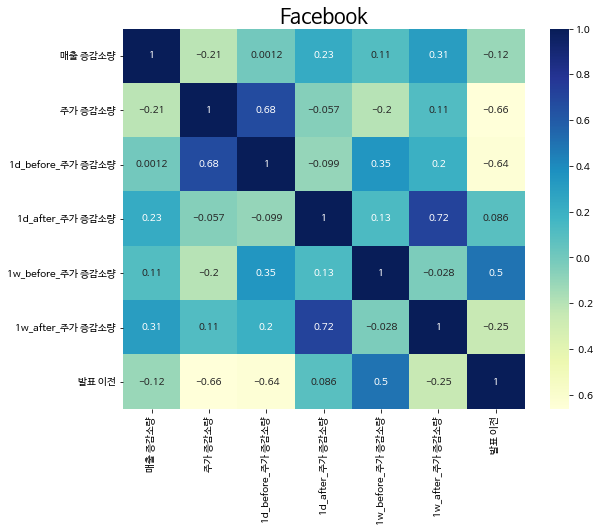

In [9]:
corr = Fb.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Facebook', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

알파벳a(구글) 주식을 전처리하는 코드입니다.

In [10]:
GoogStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
GoogStockDf['Date'] = GoogStockDf['Date'].dt.strftime("%Y-%m-%d")
GoogStockDf['Date'] = pd.to_datetime(GoogStockDf['Date'], infer_datetime_format=True)

Goog = pd.merge(GoogStockDf, GoogEarningDf)
Goog['매출 증감소량'] = (Goog['매출'] - Goog['예측'])/Goog['예측'] * 100
Goog['주가 증감소량'] = (Goog['Close'] - Goog['Open'])/Goog['Open'] * 100

GoogEarningDf['Date'] = pd.DatetimeIndex(GoogEarningDf['Date']) - timedelta(days=1)
Goog_1d_before = pd.merge(GoogStockDf, GoogEarningDf)
Goog['1d_before_주가 증감소량'] = (Goog['Close'] - Goog_1d_before['Close'])/Goog_1d_before['Close'] * 100

GoogEarningDf['Date'] = pd.DatetimeIndex(GoogEarningDf['Date']) + timedelta(days=2)
Goog_1d_after = pd.merge(GoogStockDf, GoogEarningDf)
Goog['1d_after_주가 증감소량'] = (Goog_1d_after['Close'] - Goog['Close'])/Goog['Close'] * 100

GoogEarningDf['Date'] = pd.DatetimeIndex(GoogEarningDf['Date']) - timedelta(days=1)
GoogEarningDf['Date'] = pd.DatetimeIndex(GoogEarningDf['Date']) - timedelta(weeks=1)
Goog_1w_before = pd.merge(GoogStockDf, GoogEarningDf)
Goog['1w_before_주가 증감소량'] = (Goog['Close'] - Goog_1w_before['Close'])/Goog_1w_before['Close'] * 100

GoogEarningDf['Date'] = pd.DatetimeIndex(GoogEarningDf['Date']) + timedelta(weeks=2)
Goog_1w_after = pd.merge(GoogStockDf, GoogEarningDf)
Goog['1w_after_주가 증감소량'] = (Goog_1w_after ['Close'] - Goog ['Close'])/Goog['Close'] * 100

Goog['발표 이전'] = (Goog_1d_before['Close'] - Goog_1w_before['Close'])/Goog_1w_before['Close'] * 100
Goog

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-29,1274.000000,1287.579956,36.34,37.30,-2.573727,1.065931,13.162996,-7.696608,3.102078,-7.625930,-8.890643
1,2019-07-25,1137.819946,1132.119995,38.94,38.15,2.070773,-0.500954,-11.267518,10.448543,-1.239605,6.791684,11.301288
2,2019-10-28,1275.449951,1290.000000,40.50,40.31,0.471347,1.140778,-15.244216,-2.122481,3.518836,0.106201,22.137784
3,2020-02-03,1462.000000,1485.939941,46.08,46.93,-1.811208,1.637479,-2.022923,-2.615852,3.629257,1.530352,5.768880
4,2020-04-28,1287.930054,1233.670044,41.16,40.80,0.882353,-4.212962,-35.116099,8.738960,1.424773,9.519558,56.317315
5,2020-07-30,1497.000000,1531.449951,38.30,37.33,2.598446,2.301266,-34.180443,-3.166280,1.040450,-2.047078,53.511289
6,2020-10-29,1522.359985,1567.239990,46.17,42.80,7.873832,2.948055,-43.884648,3.430873,-2.977099,12.514357,72.899034
7,2021-02-02,1922.560059,1927.510010,56.90,52.69,7.990131,0.257467,-30.551691,7.396074,0.535667,8.093343,44.763304
8,2021-04-27,2336.000000,2307.120117,55.31,51.51,7.377208,-1.236296,NaN,3.155007,0.588161,2.042801,NaN
9,2021-07-27,2800.219971,2735.929932,61.88,56.19,10.126357,-2.295892,NaN,-0.303372,4.343959,-0.377562,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


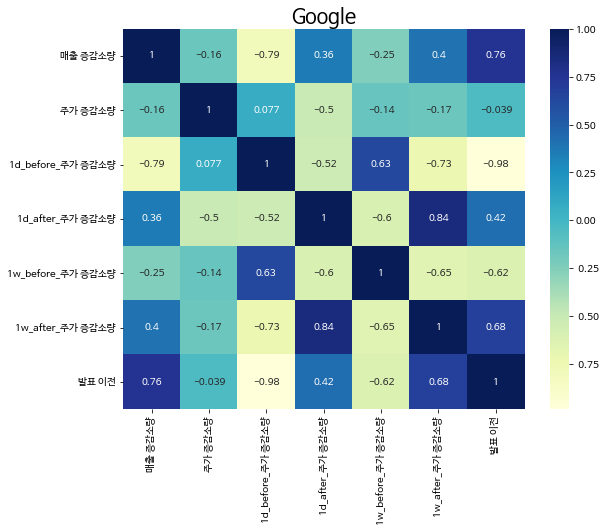

In [11]:
corr = Goog.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Google', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

아마존 주식을 전처리하는 코드입니다.

In [12]:
AmznStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
AmznStockDf['Date'] = AmznStockDf['Date'].dt.strftime("%Y-%m-%d")
AmznStockDf['Date'] = pd.to_datetime(AmznStockDf['Date'], infer_datetime_format=True)

Amzn = pd.merge(AmznStockDf, AmznEarningDf)
Amzn['매출 증감소량'] = (Amzn['매출'] - Amzn['예측'])/Amzn['예측'] * 100
Amzn['주가 증감소량'] = (Amzn['Close'] - Amzn['Open'])/Amzn['Open'] * 100

AmznEarningDf['Date'] = pd.DatetimeIndex(AmznEarningDf['Date']) - timedelta(days=1)
Amzn_1d_before = pd.merge(AmznStockDf, AmznEarningDf)
Amzn['1d_before_주가 증감소량'] = (Amzn['Close'] - Amzn_1d_before['Close'])/Amzn_1d_before['Close'] * 100

AmznEarningDf['Date'] = pd.DatetimeIndex(AmznEarningDf['Date']) + timedelta(days=2)
Amzn_1d_after = pd.merge(AmznStockDf, AmznEarningDf)
Amzn['1d_after_주가 증감소량'] = (Amzn_1d_after['Close'] - Amzn['Close'])/Amzn['Close'] * 100

AmznEarningDf['Date'] = pd.DatetimeIndex(AmznEarningDf['Date']) - timedelta(days=1)
AmznEarningDf['Date'] = pd.DatetimeIndex(AmznEarningDf['Date']) - timedelta(weeks=1)
Amzn_1w_before = pd.merge(AmznStockDf, AmznEarningDf)
Amzn['1w_before_주가 증감소량'] = (Amzn['Close'] - Amzn_1w_before['Close'])/Amzn_1w_before['Close'] * 100

AmznEarningDf['Date'] = pd.DatetimeIndex(AmznEarningDf['Date']) + timedelta(weeks=2)
Amzn_1w_after = pd.merge(AmznStockDf, AmznEarningDf)
Amzn['1w_after_주가 증감소량'] = (Amzn_1w_after ['Close'] - Amzn ['Close'])/Amzn['Close'] * 100

Amzn['발표 이전'] = (Amzn_1d_before['Close'] - Amzn_1w_before['Close'])/Amzn_1w_before['Close'] * 100
Amzn

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-25,1917.000000,1902.250000,59.70,59.70,0.000000,-0.769431,0.026292,2.543304,2.178669,-0.075177,2.151812
1,2019-07-25,2001.000000,1973.819946,63.40,62.52,1.407550,-1.358324,-1.348959,-1.558901,-0.206283,-6.003587,1.158301
2,2019-10-24,1771.089966,1780.780029,69.98,68.83,1.670783,0.547124,1.056083,-1.092222,-0.374827,-0.231359,-1.415956
3,2020-01-30,1858.000000,1870.680054,87.44,86.03,1.638963,0.682457,0.682457,7.379130,-0.737560,9.598110,-1.410392
4,2020-04-30,2419.840088,2474.000000,75.45,73.74,2.318959,2.238161,4.268960,-7.597412,3.106964,-4.300319,-1.114422
5,2020-07-30,3014.000000,3051.879883,88.91,81.45,9.158993,1.256798,0.604901,3.696084,2.187468,5.672573,1.573052
6,2020-10-29,3201.270020,3211.010010,96.15,92.78,3.632248,0.304254,1.524924,-5.445642,1.089602,3.456545,-0.428783
7,2021-02-02,3380.000000,3380.000000,125.56,119.70,4.895572,0.000000,1.110423,-1.996153,1.619604,-2.218935,0.503588
8,2021-04-29,3505.100098,3471.310059,108.53,104.51,3.846522,-0.964025,0.370393,-0.112065,4.903840,-4.751519,4.516717
9,2021-07-29,3627.750000,3599.919922,113.08,115.42,-2.027378,-0.767144,-0.837396,-7.564886,-1.047548,-6.220414,-0.211927


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


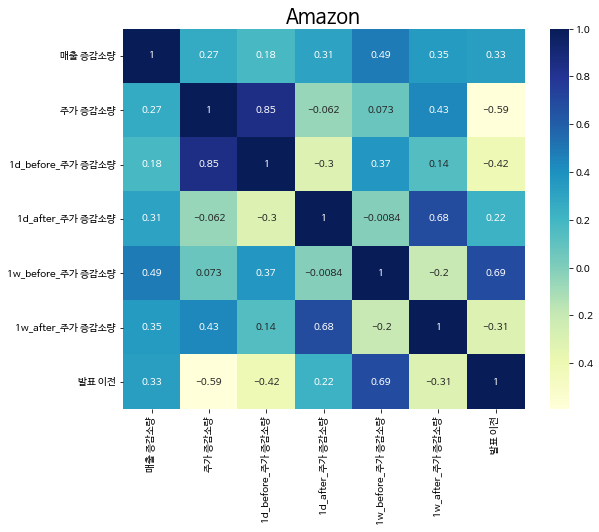

In [13]:
corr = Amzn.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Amazon', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

넷플릭스 주식을 전처리하는 코드입니다.

In [14]:
NfisStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
NfisStockDf['Date'] = NfisStockDf['Date'].dt.strftime("%Y-%m-%d")
NfisStockDf['Date'] = pd.to_datetime(NfisStockDf['Date'], infer_datetime_format=True)

Nfis = pd.merge(NfisStockDf, NfisEarningDf)
Nfis['매출 증감소량'] = (Nfis['매출'] - Nfis['예측'])/Nfis['예측'] * 100
Nfis['주가 증감소량'] = (Nfis['Close'] - Nfis['Open'])/Nfis['Open'] * 100

NfisEarningDf['Date'] = pd.DatetimeIndex(NfisEarningDf['Date']) - timedelta(days=1)
Nfis_1d_before = pd.merge(NfisStockDf, NfisEarningDf)
Nfis['1d_before_주가 증감소량'] = (Nfis['Close'] - Nfis_1d_before['Close'])/Nfis_1d_before['Close'] * 100

NfisEarningDf['Date'] = pd.DatetimeIndex(NfisEarningDf['Date']) + timedelta(days=2)
Nfis_1d_after = pd.merge(NfisStockDf, NfisEarningDf)
Nfis['1d_after_주가 증감소량'] = (Nfis_1d_after['Close'] - Nfis['Close'])/Nfis['Close'] * 100

NfisEarningDf['Date'] = pd.DatetimeIndex(NfisEarningDf['Date']) - timedelta(days=1)
NfisEarningDf['Date'] = pd.DatetimeIndex(NfisEarningDf['Date']) - timedelta(weeks=1)
Nfis_1w_before = pd.merge(NfisStockDf, NfisEarningDf)
Nfis['1w_before_주가 증감소량'] = (Nfis['Close'] - Nfis_1w_before['Close'])/Nfis_1w_before['Close'] * 100

NfisEarningDf['Date'] = pd.DatetimeIndex(NfisEarningDf['Date']) + timedelta(weeks=2)
Nfis_1w_after = pd.merge(NfisStockDf, NfisEarningDf)
Nfis['1w_after_주가 증감소량'] = (Nfis_1w_after ['Close'] - Nfis ['Close'])/Nfis['Close'] * 100

Nfis['발표 이전'] = (Nfis_1d_before['Close'] - Nfis_1w_before['Close'])/Nfis_1w_before['Close'] * 100
Nfis

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-16,355.000000,359.459991,4.52,4.50,0.444444,1.256335,3.035514,-1.313081,-1.439500,6.239922,-4.343176
1,2019-07-17,366.250000,362.440002,4.92,4.93,-0.202840,-1.040272,-0.969969,-10.272048,-4.871391,-12.277894,-3.939635
2,2019-10-16,283.119995,286.279999,5.24,5.25,-0.190476,1.116136,0.714160,2.469613,7.008560,-5.243122,6.249767
3,2020-01-21,340.000000,338.109985,5.47,5.45,0.366972,-0.555887,-22.715949,-3.581670,-0.171253,3.078881,29.171215
4,2020-04-21,444.769989,433.829987,5.77,5.75,0.347826,-2.459699,-17.090934,-2.860562,4.903881,-6.915151,26.528842
5,2020-07-16,526.479980,527.390015,6.15,6.08,1.151316,0.172853,-0.627441,-6.522692,3.866001,-9.444629,4.521814
6,2020-10-20,528.140015,525.419983,6.44,6.39,0.782473,-0.515021,-5.234114,-6.922081,-5.174257,-6.944919,0.063162
7,2021-01-19,501.000000,501.769989,6.64,6.62,0.302115,0.153690,-5.731953,16.854344,1.521495,11.989558,7.694492
8,2021-04-20,554.419983,549.570007,7.16,7.14,0.280112,-0.874784,NaN,-7.400333,-0.751264,-8.009902,NaN
9,2021-07-20,526.070007,531.049988,7.34,7.32,0.273224,0.946638,NaN,-3.280291,-1.781091,-2.286040,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


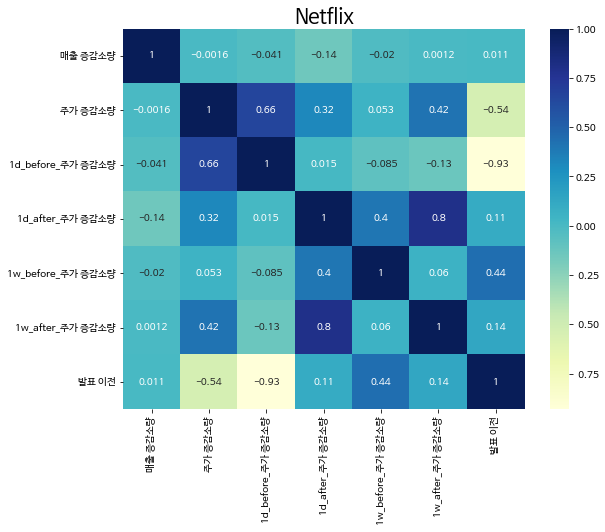

In [15]:
corr = Nfis.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Netflix', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

테슬라 주식을 전처리하는 코드입니다.

In [16]:
TslaStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
TslaStockDf['Date'] = TslaStockDf['Date'].dt.strftime("%Y-%m-%d")
TslaStockDf['Date'] = pd.to_datetime(TslaStockDf['Date'], infer_datetime_format=True)

Tsla = pd.merge(TslaStockDf, TslaEarningDf)
Tsla['매출 증감소량'] = (Tsla['매출'] - Tsla['예측'])/Tsla['예측'] * 100
Tsla['주가 증감소량'] = (Tsla['Close'] - Tsla['Open'])/Tsla['Open'] * 100

TslaEarningDf['Date'] = pd.DatetimeIndex(TslaEarningDf['Date']) - timedelta(days=1)
Tsla_1d_before = pd.merge(TslaStockDf, TslaEarningDf)
Tsla['1d_before_주가 증감소량'] = (Tsla['Close'] - Tsla_1d_before['Close'])/Tsla_1d_before['Close'] * 100

TslaEarningDf['Date'] = pd.DatetimeIndex(TslaEarningDf['Date']) + timedelta(days=2)
Tsla_1d_after = pd.merge(TslaStockDf, TslaEarningDf)
Tsla['1d_after_주가 증감소량'] = (Tsla_1d_after['Close'] - Tsla['Close'])/Tsla['Close'] * 100

TslaEarningDf['Date'] = pd.DatetimeIndex(TslaEarningDf['Date']) - timedelta(days=1)
TslaEarningDf['Date'] = pd.DatetimeIndex(TslaEarningDf['Date']) - timedelta(weeks=1)
Tsla_1w_before = pd.merge(TslaStockDf, TslaEarningDf)
Tsla['1w_before_주가 증감소량'] = (Tsla['Close'] - Tsla_1w_before['Close'])/Tsla_1w_before['Close'] * 100

TslaEarningDf['Date'] = pd.DatetimeIndex(TslaEarningDf['Date']) + timedelta(weeks=2)
Tsla_1w_after = pd.merge(TslaStockDf, TslaEarningDf)
Tsla['1w_after_주가 증감소량'] = (Tsla_1w_after ['Close'] - Tsla ['Close'])/Tsla['Close'] * 100

Tsla['발표 이전'] = (Tsla_1d_before['Close'] - Tsla_1w_before['Close'])/Tsla_1w_before['Close'] * 100
Tsla

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-24,52.770000,51.731998,4.54,5.450,-16.697248,-1.967031,-1.985603,-4.264280,-4.634443,-9.529885,-2.702502
1,2019-07-24,51.834000,52.976002,6.35,6.470,-1.854714,2.203191,1.810359,-13.613715,3.931574,-8.785116,2.083497
2,2019-10-23,50.900002,50.936001,6.30,6.430,-2.021773,0.070725,-0.352140,17.669232,-1.951877,23.688546,-1.605390
3,2020-01-29,115.138000,116.197998,7.38,7.020,5.128205,0.920633,2.485448,10.296223,2.006808,26.456569,-0.467032
4,2020-04-29,158.033997,160.102005,5.99,6.110,-1.963993,1.308584,4.081288,-2.327265,9.342864,-2.239821,5.055257
5,2020-07-22,319.799988,318.466003,6.04,6.040,0.000000,-0.417131,1.528350,-4.977608,2.996102,-5.854318,1.445657
6,2020-10-21,422.700012,422.640015,8.77,8.435,3.971547,-0.014194,0.165903,0.745314,-8.380658,-3.932431,-8.532406
7,2021-01-27,870.349976,864.159973,10.74,10.740,0.000000,-0.711208,-2.143615,-3.324614,1.612083,-1.095859,3.837970
8,2021-04-26,741.000000,738.200012,10.39,10.480,-0.858779,-0.377866,-14.586877,-4.532650,3.298211,-7.220264,20.939509
9,2021-07-26,650.969971,657.619995,11.96,11.510,3.909644,1.021556,NaN,-1.952490,1.764109,7.914903,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


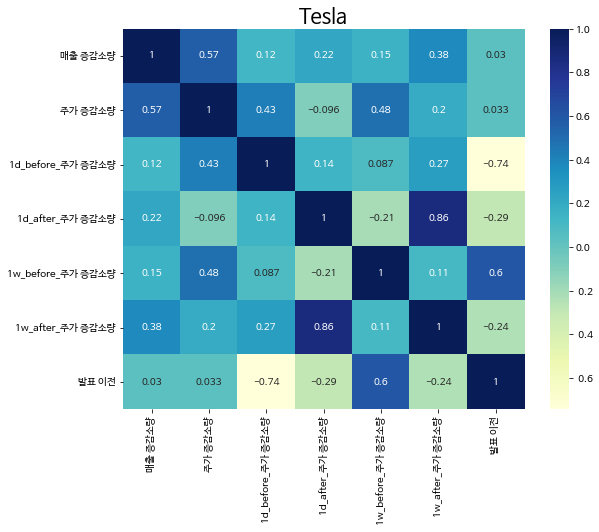

In [17]:
corr = Tsla.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Tesla', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

엔비디아 주식을 전처리하는 코드입니다.

In [18]:
NvdaStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
NvdaStockDf['Date'] = NvdaStockDf['Date'].dt.strftime("%Y-%m-%d")
NvdaStockDf['Date'] = pd.to_datetime(NvdaStockDf['Date'], infer_datetime_format=True)

Nvda = pd.merge(NvdaStockDf, NvdaEarningDf)
Nvda['매출 증감소량'] = (Nvda['매출'] - Nvda['예측'])/Nvda['예측'] * 100
Nvda['주가 증감소량'] = (Nvda['Close'] - Nvda['Open'])/Nvda['Open'] * 100

NvdaEarningDf['Date'] = pd.DatetimeIndex(NvdaEarningDf['Date']) - timedelta(days=1)
Nvda_1d_before = pd.merge(NvdaStockDf, NvdaEarningDf)
Nvda['1d_before_주가 증감소량'] = (Nvda['Close'] - Nvda_1d_before['Close'])/Nvda_1d_before['Close'] * 100

NvdaEarningDf['Date'] = pd.DatetimeIndex(NvdaEarningDf['Date']) + timedelta(days=2)
Nvda_1d_after = pd.merge(NvdaStockDf, NvdaEarningDf)
Nvda['1d_after_주가 증감소량'] = (Nvda_1d_after['Close'] - Nvda['Close'])/Nvda['Close'] * 100

NvdaEarningDf['Date'] = pd.DatetimeIndex(NvdaEarningDf['Date']) - timedelta(days=1)
NvdaEarningDf['Date'] = pd.DatetimeIndex(NvdaEarningDf['Date']) - timedelta(weeks=1)
Nvda_1w_before = pd.merge(NvdaStockDf, NvdaEarningDf)
Nvda['1w_before_주가 증감소량'] = (Nvda['Close'] - Nvda_1w_before['Close'])/Nvda_1w_before['Close'] * 100

NvdaEarningDf['Date'] = pd.DatetimeIndex(NvdaEarningDf['Date']) + timedelta(weeks=2)
Nvda_1w_after = pd.merge(NvdaStockDf, NvdaEarningDf)
Nvda['1w_after_주가 증감소량'] = (Nvda_1w_after ['Close'] - Nvda ['Close'])/Nvda['Close'] * 100

Nvda['발표 이전'] = (Nvda_1d_before['Close'] - Nvda_1w_before['Close'])/Nvda_1w_before['Close'] * 100
Nvda

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-05-16,39.840000,40.047501,2.22,2.20,0.909091,0.520836,0.382256,-2.284789,-5.875786,-8.034207,-6.234211
1,2019-08-15,37.707500,37.192501,2.58,2.55,1.176471,-1.365773,-0.866265,7.252801,-5.996457,15.265169,-5.175021
2,2019-11-14,52.232498,52.447498,3.01,2.92,3.082192,0.411621,0.584928,-2.669330,0.695976,0.185900,0.110402
3,2020-02-13,67.552498,67.695000,3.11,2.96,5.067568,0.210950,-0.645780,7.020462,6.501475,14.003993,7.193710
4,2020-05-21,90.514999,87.752502,3.08,2.97,3.703704,-3.051977,-2.171120,2.860312,9.274020,-3.284805,11.699143
5,2020-11-18,134.652496,134.287506,4.73,4.42,7.013575,-0.271061,2.137258,0.085630,0.080126,-1.444663,-2.014086
6,2021-02-24,141.227493,144.990005,5.00,4.82,3.734440,2.664150,8.022128,-8.217813,-2.730439,-11.685291,-9.954041
7,2021-05-26,157.342499,157.000000,5.66,5.40,4.814815,-0.217677,11.016831,-1.350315,11.618647,6.867835,0.542095
8,2021-08-18,195.000000,190.399994,6.51,6.33,2.843602,-2.358977,21.678837,3.981094,-3.345353,16.664922,-20.565770


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


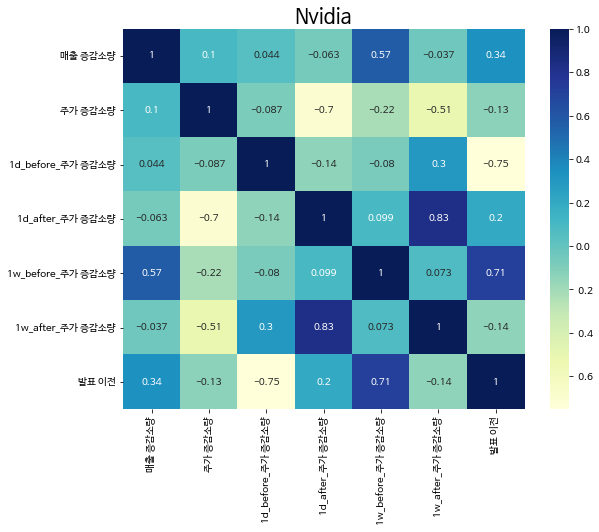

In [19]:
corr = Nvda.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Nvidia', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

스타벅스 주식을 전처리하는 코드입니다.

In [20]:
SbuxStockDf.drop(['High', 'Low','Volume','Dividends','Stock Splits'], axis=1, inplace=True)
SbuxStockDf['Date'] = SbuxStockDf['Date'].dt.strftime("%Y-%m-%d")
SbuxStockDf['Date'] = pd.to_datetime(SbuxStockDf['Date'], infer_datetime_format=True)

Sbux = pd.merge(SbuxStockDf, SbuxEarningDf)
Sbux['매출 증감소량'] = (Sbux['매출'] - Sbux['예측'])/Sbux['예측'] * 100
Sbux['주가 증감소량'] = (Sbux['Close'] - Sbux['Open'])/Sbux['Open'] * 100

SbuxEarningDf['Date'] = pd.DatetimeIndex(SbuxEarningDf['Date']) - timedelta(days=1)
Sbux_1d_before = pd.merge(SbuxStockDf, SbuxEarningDf)
Sbux['1d_before_주가 증감소량'] = (Sbux['Close'] - Sbux_1d_before['Close'])/Sbux_1d_before['Close'] * 100

SbuxEarningDf['Date'] = pd.DatetimeIndex(SbuxEarningDf['Date']) + timedelta(days=2)
Sbux_1d_after = pd.merge(SbuxStockDf, SbuxEarningDf)
Sbux['1d_after_주가 증감소량'] = (Sbux_1d_after['Close'] - Sbux['Close'])/Sbux['Close'] * 100

SbuxEarningDf['Date'] = pd.DatetimeIndex(SbuxEarningDf['Date']) - timedelta(days=1)
SbuxEarningDf['Date'] = pd.DatetimeIndex(SbuxEarningDf['Date']) - timedelta(weeks=1)
Sbux_1w_before = pd.merge(SbuxStockDf, SbuxEarningDf)
Sbux['1w_before_주가 증감소량'] = (Sbux['Close'] - Sbux_1w_before['Close'])/Sbux_1w_before['Close'] * 100

SbuxEarningDf['Date'] = pd.DatetimeIndex(SbuxEarningDf['Date']) + timedelta(weeks=2)
Sbux_1w_after = pd.merge(SbuxStockDf, SbuxEarningDf)
Sbux['1w_after_주가 증감소량'] = (Sbux_1w_after ['Close'] - Sbux ['Close'])/Sbux['Close'] * 100

Sbux['발표 이전'] = (Sbux_1d_before['Close'] - Sbux_1w_before['Close'])/Sbux_1w_before['Close'] * 100
Sbux

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-25,72.695106,73.650238,6.31,6.32,-0.158228,1.313888,0.942515,0.440939,1.380504,0.466878,0.433899
1,2019-07-25,87.790436,87.301064,6.62,6.67,-0.749625,-0.557432,0.364031,8.936036,-0.568303,4.836226,-0.928952
2,2019-10-30,81.496377,81.091835,6.75,6.68,1.047904,-0.496393,0.071328,0.439482,1.752483,-1.425363,1.679956
3,2020-01-28,86.201755,85.766144,7.10,6.48,9.567901,-0.505339,-0.146491,-2.121916,-4.247254,-0.248329,-4.106779
4,2020-04-28,76.508667,76.528122,6.00,5.89,1.867572,0.025428,1.222017,-2.325582,8.209583,-7.357985,6.903207
5,2020-07-28,74.623132,72.999611,4.22,4.10,2.926829,-2.175627,-2.380326,3.724554,-1.060455,0.656476,1.352055
6,2020-10-29,85.717996,86.829178,6.20,6.06,2.310231,1.296323,1.296324,-1.517555,-1.186213,2.627408,-2.450767
7,2021-01-26,102.157123,103.431618,6.75,6.91,-2.315485,1.247583,1.198657,-6.514470,2.096739,-2.903816,0.887445
8,2021-04-27,114.766149,115.242401,6.67,6.78,-1.622419,0.414977,0.198406,-3.228582,-0.103210,-1.756346,-0.301019
9,2021-07-27,125.592534,125.542725,7.50,7.29,2.880658,-0.039660,-0.023798,-2.872325,7.332648,-5.474886,7.358197


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


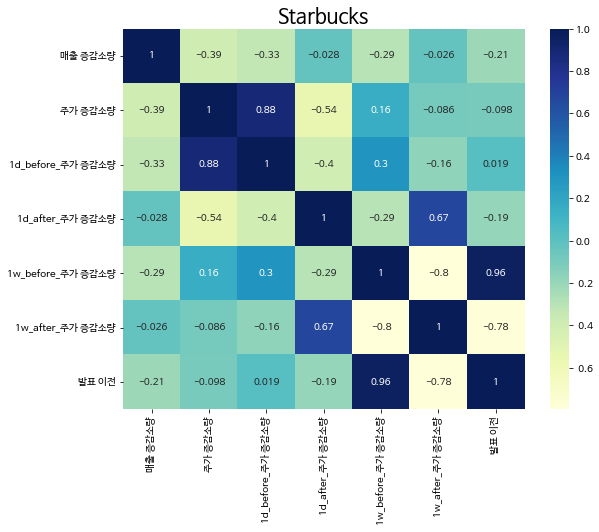

In [21]:
corr = Sbux.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Starbucks', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

포드 주식을 전처리하는 코드입니다.

In [22]:
FStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
FStockDf['Date'] = FStockDf['Date'].dt.strftime("%Y-%m-%d")
FStockDf['Date'] = pd.to_datetime(FStockDf['Date'], infer_datetime_format=True)

F = pd.merge(FStockDf, FEarningDf)
F['매출 증감소량'] = (F['매출'] - F['예측'])/F['예측'] * 100
F['주가 증감소량'] = (F['Close'] - F['Open'])/F['Open'] * 100

FEarningDf['Date'] = pd.DatetimeIndex(FEarningDf['Date']) - timedelta(days=1)
F_1d_before = pd.merge(FStockDf, FEarningDf)
F['1d_before_주가 증감소량'] = (F['Close'] - F_1d_before['Close'])/F_1d_before['Close'] * 100

FEarningDf['Date'] = pd.DatetimeIndex(FEarningDf['Date']) + timedelta(days=2)
F_1d_after = pd.merge(FStockDf, FEarningDf)
F['1d_after_주가 증감소량'] = (F_1d_after['Close'] - F['Close'])/F['Close'] * 100

FEarningDf['Date'] = pd.DatetimeIndex(FEarningDf['Date']) - timedelta(days=1)
FEarningDf['Date'] = pd.DatetimeIndex(FEarningDf['Date']) - timedelta(weeks=1)
F_1w_before = pd.merge(FStockDf, FEarningDf)
F['1w_before_주가 증감소량'] = (F['Close'] - F_1w_before['Close'])/F_1w_before['Close'] * 100

FEarningDf['Date'] = pd.DatetimeIndex(FEarningDf['Date']) + timedelta(weeks=2)
F_1w_after = pd.merge(FStockDf, FEarningDf)
F['1w_after_주가 증감소량'] = (F_1w_after ['Close'] - F ['Close'])/F['Close'] * 100

F['발표 이전'] = (F_1d_before['Close'] - F_1w_before['Close'])/F_1w_before['Close'] * 100
F

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-25,9.52,9.40,40.34,40.30,0.099256,-1.260504,-1.776385,10.744681,-1.570681,10.000000,0.209424
1,2019-07-24,10.18,10.33,38.85,38.63,0.569506,1.473477,1.573255,-7.454017,0.000000,-7.744434,-1.548887
2,2019-10-23,9.01,9.21,36.99,36.87,0.325468,2.219756,1.543550,-6.623236,1.543550,-7.274701,0.000000
3,2020-02-04,9.08,9.18,39.70,39.63,0.176634,1.101322,2.227171,-9.477124,2.341137,-11.764706,0.111483
4,2020-04-28,5.49,5.38,34.32,34.69,-1.066590,-2.003643,4.061896,-2.230483,12.788260,-7.620818,8.385744
5,2020-07-30,6.74,6.74,19.37,19.35,0.103359,0.000000,-2.601156,-1.928783,-3.438395,2.818991,-0.859599
6,2020-10-28,7.68,7.70,37.50,35.72,4.983203,0.260417,-2.777778,2.597403,-1.910828,-0.779221,0.891720
7,2021-02-04,11.40,11.37,36.00,36.77,-2.094098,-0.263158,1.517857,1.231310,6.063433,0.703606,4.477612
8,2021-04-28,12.60,12.43,36.23,36.13,0.276778,-1.349206,-0.480384,-9.412711,5.967604,-6.596943,6.479113
9,2021-07-28,13.86,13.86,26.75,24.72,8.211974,0.000000,0.507614,3.823954,-2.325581,-3.896104,-2.818887


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


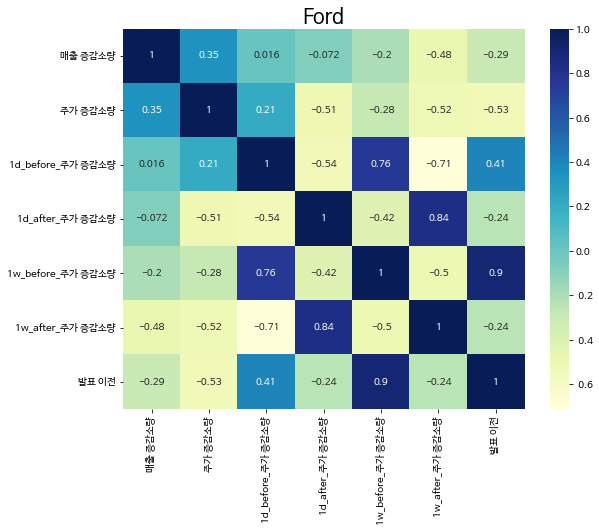

In [23]:
corr = F.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Ford', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

화이자 주식을 전처리하는 코드입니다.

In [24]:
PfeStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
PfeStockDf['Date'] = PfeStockDf['Date'].dt.strftime("%Y-%m-%d")
PfeStockDf['Date'] = pd.to_datetime(PfeStockDf['Date'], infer_datetime_format=True)

Pfe = pd.merge(PfeStockDf, PfeEarningDf)
Pfe['매출 증감소량'] = (Pfe['매출'] - Pfe['예측'])/Pfe['예측'] * 100
Pfe['주가 증감소량'] = (Pfe['Close'] - Pfe['Open'])/Pfe['Open'] * 100

PfeEarningDf['Date'] = pd.DatetimeIndex(PfeEarningDf['Date']) - timedelta(days=1)
Pfe_1d_before = pd.merge(PfeStockDf, PfeEarningDf)
Pfe['1d_before_주가 증감소량'] = (Pfe['Close'] - Pfe_1d_before['Close'])/Pfe_1d_before['Close'] * 100

PfeEarningDf['Date'] = pd.DatetimeIndex(PfeEarningDf['Date']) + timedelta(days=2)
Pfe_1d_after = pd.merge(PfeStockDf, PfeEarningDf)
Pfe['1d_after_주가 증감소량'] = (Pfe_1d_after['Close'] - Pfe['Close'])/Pfe['Close'] * 100

PfeEarningDf['Date'] = pd.DatetimeIndex(PfeEarningDf['Date']) - timedelta(days=1)
PfeEarningDf['Date'] = pd.DatetimeIndex(PfeEarningDf['Date']) - timedelta(weeks=1)
Pfe_1w_before = pd.merge(PfeStockDf, PfeEarningDf)
Pfe['1w_before_주가 증감소량'] = (Pfe['Close'] - Pfe_1w_before['Close'])/Pfe_1w_before['Close'] * 100

PfeEarningDf['Date'] = pd.DatetimeIndex(PfeEarningDf['Date']) + timedelta(weeks=2)
Pfe_1w_after = pd.merge(PfeStockDf, PfeEarningDf)
Pfe['1w_after_주가 증감소량'] = (Pfe_1w_after ['Close'] - Pfe ['Close'])/Pfe['Close'] * 100

Pfe['발표 이전'] = (Pfe_1d_before['Close'] - Pfe_1w_before['Close'])/Pfe_1w_before['Close'] * 100
Pfe

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-07-29,40.009487,39.326378,13.26,13.40,-1.044776,-1.707368,11.185632,-6.417372,-3.199434,-10.832332,-12.937882
1,2019-10-29,36.053131,36.252373,12.68,12.26,3.425775,0.552634,-4.855575,0.706613,4.886084,-1.910498,10.238813
2,2020-01-28,37.305504,36.185959,12.69,12.61,0.634417,-3.001018,-0.495688,-1.468279,-5.453648,-1.179864,-4.982658
3,2020-04-28,37.049335,35.967743,12.03,11.81,1.862828,-2.919329,0.985616,0.553946,6.428974,1.582696,5.390230
4,2020-07-28,36.565464,37.020874,11.80,11.54,2.253033,1.245465,2.900846,0.615067,6.350510,-1.614562,3.352415
5,2020-10-27,35.142315,35.512333,12.13,12.31,-1.462226,1.052913,-0.803536,-5.289866,-0.160045,-3.312855,0.648703
6,2021-02-02,35.759998,34.990002,11.68,11.47,1.830863,-2.153233,-12.151644,-0.428700,-6.218169,-0.057162,6.754224
7,2021-05-04,40.000000,39.950001,14.58,13.65,6.813187,-0.124997,-5.106881,0.050063,3.901170,-1.501885,9.492840
8,2021-07-28,42.349998,43.450001,18.98,18.71,1.443079,2.597410,-0.435376,-1.518987,5.923942,4.004598,6.387126
9,2021-11-02,45.080002,45.450001,24.09,22.58,6.687334,0.820761,NaN,-1.386141,4.338843,4.070403,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


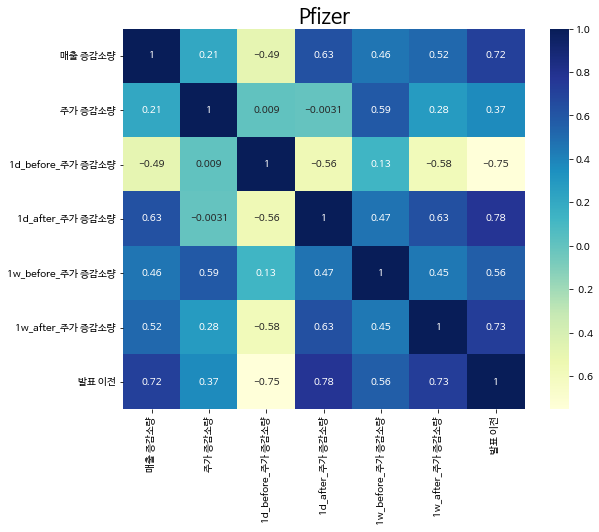

In [25]:
corr = Pfe.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Pfizer', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

TSMC 주식을 전처리하는 코드입니다.

In [26]:
TsmStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
TsmStockDf['Date'] = TsmStockDf['Date'].dt.strftime("%Y-%m-%d")
TsmStockDf['Date'] = pd.to_datetime(TsmStockDf['Date'], infer_datetime_format=True)

Tsm = pd.merge(TsmStockDf, TsmEarningDf)
Tsm['매출 증감소량'] = (Tsm['매출'] - Tsm['예측'])/Tsm['예측'] * 100
Tsm['주가 증감소량'] = (Tsm['Close'] - Tsm['Open'])/Tsm['Open'] * 100

TsmEarningDf['Date'] = pd.DatetimeIndex(TsmEarningDf['Date']) - timedelta(days=1)
Tsm_1d_before = pd.merge(TsmStockDf, TsmEarningDf)
Tsm['1d_before_주가 증감소량'] = (Tsm['Close'] - Tsm_1d_before['Close'])/Tsm_1d_before['Close'] * 100

TsmEarningDf['Date'] = pd.DatetimeIndex(TsmEarningDf['Date']) + timedelta(days=2)
Tsm_1d_after = pd.merge(TsmStockDf, TsmEarningDf)
Tsm['1d_after_주가 증감소량'] = (Tsm_1d_after['Close'] - Tsm['Close'])/Tsm['Close'] * 100

TsmEarningDf['Date'] = pd.DatetimeIndex(TsmEarningDf['Date']) - timedelta(days=1)
TsmEarningDf['Date'] = pd.DatetimeIndex(TsmEarningDf['Date']) - timedelta(weeks=1)
Tsm_1w_before = pd.merge(TsmStockDf, TsmEarningDf)
Tsm['1w_before_주가 증감소량'] = (Tsm['Close'] - Tsm_1w_before['Close'])/Tsm_1w_before['Close'] * 100

TsmEarningDf['Date'] = pd.DatetimeIndex(TsmEarningDf['Date']) + timedelta(weeks=2)
Tsm_1w_after = pd.merge(TsmStockDf, TsmEarningDf)
Tsm['1w_after_주가 증감소량'] = (Tsm_1w_after ['Close'] - Tsm ['Close'])/Tsm['Close'] * 100

Tsm['발표 이전'] = (Tsm_1d_before['Close'] - Tsm_1w_before['Close'])/Tsm_1w_before['Close'] * 100
Tsm

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-04-17,43.900002,44.389999,7.09,7.14,-0.700280,1.116166,3.208559,2.275294,4.767524,2.297817,1.510500
1,2019-07-18,42.520000,43.189999,7.76,7.62,1.837270,1.575727,3.747293,1.481831,5.599014,0.995601,1.784839
2,2019-10-17,51.139999,49.750000,9.58,9.25,3.567568,-2.718027,-0.758031,-0.944726,1.675863,2.412062,2.452485
3,2020-01-17,58.639999,58.580002,10.60,10.50,0.952381,-0.102314,-0.289358,13.673598,-0.475703,-1.451011,-0.186886
4,2020-07-15,67.180000,66.059998,10.55,10.39,1.539942,-1.667166,25.279723,33.439305,5.544013,3.739027,-15.753315
5,2020-10-14,89.650002,88.599998,12.40,11.84,4.729730,-1.171226,32.317801,41.343122,1.932812,-1.083520,-22.963644
6,2021-01-14,123.449997,126.449997,12.93,12.85,0.622568,2.430134,41.064255,-6.405693,4.134067,6.097277,-26.179693
7,2021-04-14,121.989998,120.839996,12.77,12.78,-0.078247,-0.942702,1.350325,NaN,0.792391,-2.846735,-0.550501


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


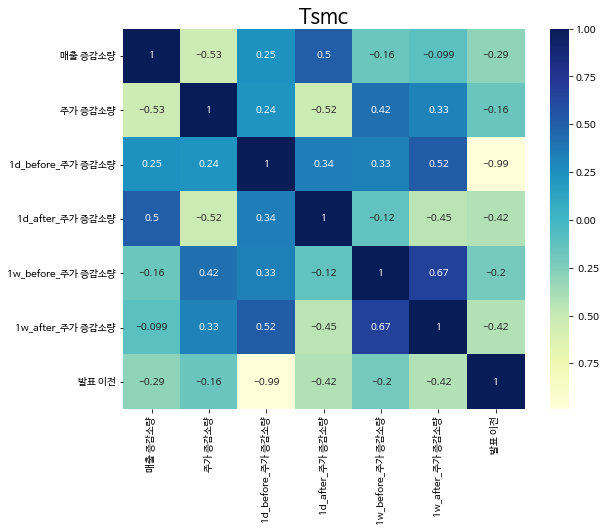

In [27]:
corr = Tsm.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Tsmc', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

퀄컴 주식을 전처리하는 코드입니다.

In [28]:
QcomStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
QcomStockDf['Date'] = QcomStockDf['Date'].dt.strftime("%Y-%m-%d")
QcomStockDf['Date'] = pd.to_datetime(QcomStockDf['Date'], infer_datetime_format=True)

Qcom = pd.merge(QcomStockDf, QcomEarningDf)
Qcom['매출 증감소량'] = (Qcom['매출'] - Qcom['예측'])/Qcom['예측'] * 100
Qcom['주가 증감소량'] = (Qcom['Close'] - Qcom['Open'])/Qcom['Open'] * 100

QcomEarningDf['Date'] = pd.DatetimeIndex(QcomEarningDf['Date']) - timedelta(days=1)
Qcom_1d_before = pd.merge(QcomStockDf, QcomEarningDf)
Qcom['1d_before_주가 증감소량'] = (Qcom['Close'] - Qcom_1d_before['Close'])/Qcom_1d_before['Close'] * 100

QcomEarningDf['Date'] = pd.DatetimeIndex(QcomEarningDf['Date']) + timedelta(days=2)
Qcom_1d_after = pd.merge(QcomStockDf, QcomEarningDf)
Qcom['1d_after_주가 증감소량'] = (Qcom_1d_after['Close'] - Qcom['Close'])/Qcom['Close'] * 100

QcomEarningDf['Date'] = pd.DatetimeIndex(QcomEarningDf['Date']) - timedelta(days=1)
QcomEarningDf['Date'] = pd.DatetimeIndex(QcomEarningDf['Date']) - timedelta(weeks=1)
Qcom_1w_before = pd.merge(QcomStockDf, QcomEarningDf)
Qcom['1w_before_주가 증감소량'] = (Qcom['Close'] - Qcom_1w_before['Close'])/Qcom_1w_before['Close'] * 100

QcomEarningDf['Date'] = pd.DatetimeIndex(QcomEarningDf['Date']) + timedelta(weeks=2)
Qcom_1w_after = pd.merge(QcomStockDf, QcomEarningDf)
Qcom['1w_after_주가 증감소량'] = (Qcom_1w_after ['Close'] - Qcom ['Close'])/Qcom['Close'] * 100

Qcom['발표 이전'] = (Qcom_1d_before['Close'] - Qcom_1w_before['Close'])/Qcom_1w_before['Close'] * 100
Qcom

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2019-05-01,87.169998,86.370003,4.88,4.80,1.666667,-0.917741,0.278656,0.891509,-0.529770,-2.118793,-0.806179
1,2019-07-31,74.830002,73.160004,4.89,5.09,-3.929273,-2.231723,-2.205580,-2.679069,-3.571898,-5.139423,-1.397133
2,2019-11-06,85.339996,84.629997,4.80,4.71,1.910828,-0.831965,-0.971217,6.321643,3.916988,6.900631,4.936146
3,2020-02-05,90.989998,90.910004,5.06,4.84,4.545455,-0.087915,2.226475,-0.330000,3.037517,0.890988,0.793378
4,2020-04-29,77.169998,78.970001,5.21,5.03,3.578529,2.332517,4.887767,-0.379895,5.744511,-0.126628,0.816820
5,2020-07-29,92.080002,93.029999,4.89,4.81,1.663202,1.031708,1.727722,15.220900,0.464364,19.735569,-1.241902
6,2020-11-04,129.320007,128.970001,6.50,5.90,10.169492,-0.270651,2.805902,12.747153,6.078301,14.515004,3.183085
7,2021-02-03,167.580002,162.300003,8.23,8.26,-0.363196,-3.150733,-1.505035,-8.829329,5.615934,-10.351203,7.229779
8,2021-04-28,138.169998,136.570007,7.93,7.62,4.068241,-1.157987,-1.043394,4.473886,0.279026,-1.405882,1.336363
9,2021-07-28,141.270004,142.440002,8.00,7.53,6.241700,0.828200,1.071460,6.002529,0.189916,4.057848,-0.872199


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


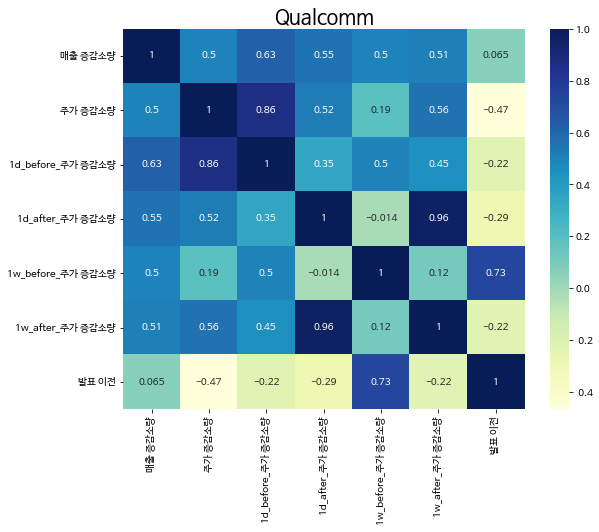

In [29]:
corr = Qcom.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Qualcomm', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

우버 주식을 전처리하는 코드입니다.

In [30]:
UberStockDf.drop(['High', 'Low','Volume','Adj Close'], axis=1, inplace=True)
UberStockDf['Date'] = UberStockDf['Date'].dt.strftime("%Y-%m-%d")
UberStockDf['Date'] = pd.to_datetime(UberStockDf['Date'], infer_datetime_format=True)

Uber = pd.merge(UberStockDf, UberEarningDf)
Uber['매출 증감소량'] = (Uber['매출'] - Uber['예측'])/Uber['예측'] * 100
Uber['주가 증감소량'] = (Uber['Close'] - Uber['Open'])/Uber['Open'] * 100

UberEarningDf['Date'] = pd.DatetimeIndex(UberEarningDf['Date']) - timedelta(days=1)
Uber_1d_before = pd.merge(UberStockDf, UberEarningDf)
Uber['1d_before_주가 증감소량'] = (Uber['Close'] - Uber_1d_before['Close'])/Uber_1d_before['Close'] * 100

UberEarningDf['Date'] = pd.DatetimeIndex(UberEarningDf['Date']) + timedelta(days=2)
Uber_1d_after = pd.merge(UberStockDf, UberEarningDf)
Uber['1d_after_주가 증감소량'] = (Uber_1d_after['Close'] - Uber['Close'])/Uber['Close'] * 100

UberEarningDf['Date'] = pd.DatetimeIndex(UberEarningDf['Date']) - timedelta(days=1)
UberEarningDf['Date'] = pd.DatetimeIndex(UberEarningDf['Date']) - timedelta(weeks=1)
Uber_1w_before = pd.merge(UberStockDf, UberEarningDf)
Uber['1w_before_주가 증감소량'] = (Uber['Close'] - Uber_1w_before['Close'])/Uber_1w_before['Close'] * 100

UberEarningDf['Date'] = pd.DatetimeIndex(UberEarningDf['Date']) + timedelta(weeks=2)
Uber_1w_after = pd.merge(UberStockDf, UberEarningDf)
Uber['1w_after_주가 증감소량'] = (Uber_1w_after ['Close'] - Uber ['Close'])/Uber['Close'] * 100

Uber['발표 이전'] = (Uber_1d_before['Close'] - Uber_1w_before['Close'])/Uber_1w_before['Close'] * 100
Uber

,Date,Open,Close,매출,예측,매출 증감소량,주가 증감소량,1d_before_주가 증감소량,1d_after_주가 증감소량,1w_before_주가 증감소량,1w_after_주가 증감소량,발표 이전
0,2020-02-06,37.299999,37.090000,4.07,4.07,0.000000,-0.563000,0.760660,9.544354,1.117775,8.088434,0.354419
1,2020-05-07,29.600000,30.930000,3.54,3.53,0.283286,4.493243,11.179008,6.013582,2.180377,6.013582,-8.093822
2,2020-08-06,33.270000,34.709999,2.24,2.08,7.692308,4.328221,4.548187,-5.214627,14.781743,-12.244310,9.788363
3,2020-11-05,40.330002,41.959999,3.13,3.20,-2.187500,4.041649,2.366423,6.935177,23.194356,10.581514,20.346450
4,2021-02-10,62.000000,63.180000,3.17,3.16,0.316456,1.903226,5.988926,-3.909467,10.609246,-3.751186,4.359247
5,2021-05-05,53.869999,51.180000,2.90,3.27,-11.314985,-4.993501,-3.415742,-8.851110,-12.422996,-14.400154,-9.325799
6,2021-08-04,42.700001,41.810001,3.93,3.76,4.521277,-2.084309,-2.290255,3.013631,-9.384478,3.037553,-7.260507
7,2021-11-04,45.540001,45.270000,4.85,4.42,9.728507,-0.592888,-0.984254,4.241217,1.456748,-4.395849,2.465267


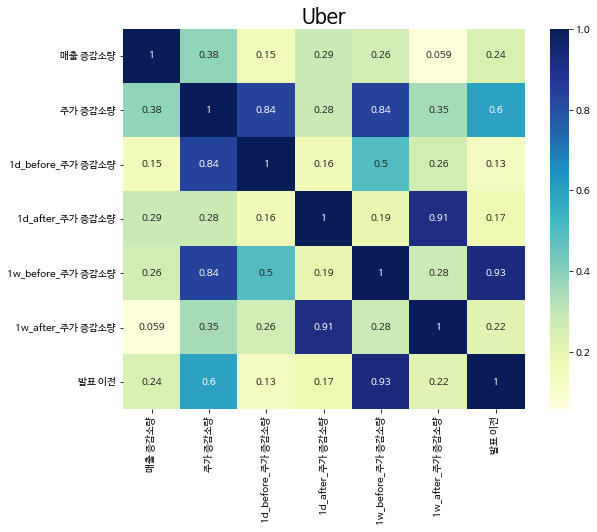

In [31]:
corr = Uber.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Uber', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

# 3. 지금까지 전처리한 데이터를 하나로 합쳐서 연관성을 파악하는 과정입니다.

전처리한 데이터 간의 관계를 heatmap를 통해 Correlation을 확인하는 코드입니다.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


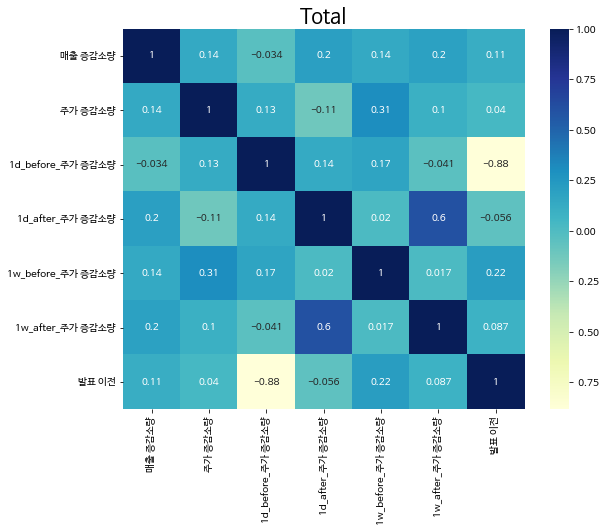

In [32]:
total = pd.concat([Apple, Goog, Fb, Amzn, Nfis, Tsla, Nvda, Sbux, F, Pfe, Tsm, Qcom, Uber])

corr = total.loc[:, ['매출 증감소량', '주가 증감소량', '1d_before_주가 증감소량', '1d_after_주가 증감소량', '1w_before_주가 증감소량', '1w_after_주가 증감소량', '발표 이전']].corr()

f, ax = plt.subplots(figsize=(9, 7))
plt.title('Total', fontsize=20)
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

# 4. 위에 파악한 연관 관계를 통해 독립변수와 종속 변수를 정하여 LinearRegression로 fit 후에 정확도를 확인하는 코드입니다.

1d_after_주가 증감소량과 1w_after_주가 증감소량과의 연관성이 다른 변수에 비해 높아서 주가 발표 하루 후 주가의 경향으로 1주일 이후의 주가를 파악하는 코드입니다.

R2-score을 출력하여 모델을 판단하는 코드입니다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

total = total.dropna(axis=0)

X = total[['1d_after_주가 증감소량']]
y = total['1w_after_주가 증감소량']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LR = LinearRegression()
LR.fit(X_train, y_train)

y_prediction =  LR.predict(X_test)

score=r2_score(y_test,y_prediction)

print('r2 socre is %.4f'%score)

r2 socre is 0.4449


데이터가 많지 않아서 cross_val_score통해 여러번 교차 검증을 통해 Root_Mean_Squared_Error값의 평균을 출력하는 코드입니다.

In [ ]:
from sklearn.model_selection import cross_val_score

total = total.dropna(axis=0)

X = total[['1d_after_주가 증감소량']]
y = total['1w_after_주가 증감소량']

LR = LinearRegression()

MSE_scores = cross_val_score(LR, X, y, cv=100, scoring='neg_mean_squared_error')
RMSE_scores = np.sqrt(-MSE_scores)
RMSE_mean = RMSE_scores.mean()
print(RMSE_mean)

4.842859048092717


# 개선이 필요한점, 어려웠던 점


1.   LinearRegression 모델의 정확도가 높지 않아서 실제 사용하지는 못하지만 실적 발표 후 어느 정도의 방향성이 존재 할 수 있다는 사실을 알게 되었습니다.
2.   기회가 된다면 더 많은 기업을 분석하여 모든 기업의 실적 발표와 주가의 상관관계를 더 자세히 알아보고 싶습니다.
3.   기업의 주가는 매우 많은 변수가 존재하기 때문에 한가지의 변수로 예측하기는 쉽지 않았습니다.
4.   기업의 실적을 받아오는 과정을 크롤링을 통헤 다량의 데이터를 빠르게 가지고 오고 싶었으나 respones 403을 반환하여 웹 사이트에서 막아서 직접 손으로 만드는 과정이 오래 걸렸습니다.



# 끝까지 코드를 봐주셔서 감사합니다!!